# From the address to the 3D

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import geopy as gp
import folium

from shapely.geometry import Point, Polygon

import rasterio as rio
from rasterio.plot import show
from rasterio.windows import Window

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [2]:
from functions import *

## Enter an address, get a location

In [15]:
# Google API

country_code = -1

while country_code != 'BE':
    address = input("Please, enter an address in Begium:\n")

    locator = gp.geocoders.GoogleV3(api_key='')
    location = locator.geocode(address, timeout=10)

    postcode = int(location.raw['address_components'][-1]['long_name'])
    country_code = location.raw['address_components'][-2]['short_name']
    coord = (location.latitude, location.longitude)

print("Latitude = {}, Longitude = {}, Postcode = {}".format(coord[1], coord[0], postcode))

Please, enter an address in Begium:
rue neuve, 39, 1350
Latitude = 4.9318328, Longitude = 50.6588103, Postcode = 1350


In [3]:
# OpenStreet Map (gratuit, moins efficace)

country_code = -1

while country_code != 'be':
    address = input("Please, enter an address in Begium:\n")

    locator = gp.Nominatim(user_agent="myGeocoder")
    location = locator.geocode(address, addressdetails=True)
    
    postcode = int(location.raw['address']['postcode'])
    country_code = location.raw['address']['country_code']
    coord = (location.latitude, location.longitude)

print("Latitude = {}, Longitude = {}, Postcode = {}".format(coord[0], coord[1], postcode))

Please, enter an address in Begium:
Gare de Namur
Latitude = 50.469100100000006, Longitude = 4.862421313946799, Postcode = 5000


In [5]:
mappy = folium.Map(
    location=[coord[0],coord[1]],
    zoom_start=17
)

folium.CircleMarker(
    location=[coord[0],coord[1]],
    radius=30,
    popup='Your address',
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
).add_to(mappy)

mappy

## From coordinates to correct crs

In [7]:
p = gpd.GeoSeries([Point(coord[1], coord[0])])
p.crs = 'epsg:4326'
p = p.to_crs(epsg=31370)
print(p[0])

POINT (189813.7284753995 149950.3678983543)


## Get a Polygon around the point

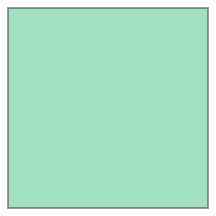

In [12]:
x = p[0].x
y = p[0].y

poly = Polygon([(x+100, y+100), (x-100, y+100), (x-100, y-100), (x+100, y-100)])
poly

## Get the corrects LiDAR files' path

In [16]:
path_dsm = ""
path_dtm = ""
flanders = False

if postcode >= 1300 and postcode < 1500:
    path_dsm = set_path_dsm('BRABANT_WALLON')
    path_dtm = set_path_dtm('BRABANT_WALLON')
    print('Walloon Brabant')
    
elif postcode >= 4000 and postcode < 5000:
    path_dsm = set_path_dsm('LIEGE')
    path_dtm = set_path_dtm('LIEGE')
    print('Liège')
    
elif postcode >= 5000 and postcode < 6000:
    path_dsm = set_path_dsm('NAMUR')
    path_dtm = set_path_dtm('NAMUR')
    print('Namur')
    
elif (postcode >= 6000 and postcode < 6600) or (postcode >= 7000 and postcode < 8000):
    path_dsm = set_path_dsm('HAINAUT')
    path_dtm = set_path_dtm('HAINAUT')
    print('Hainaut')
    
elif postcode >= 6600 and postcode < 7000:
    path_dsm = set_path_dsm('LUXEMBOURG')
    path_dtm = set_path_dtm('LUXEMBOURG')
    print('Luxembourg')
    
else:
    number = [x for x in range(1, 44)]
    for i in number :
        path_dsm = f'/home/demes/Documents/Resources/Flandre/DSM/DHMVIIDSMRAS1m_k{i:02}/GeoTIFF/DHMVIIDSMRAS1m_k{i:02}.tif'
        with rio.open(path_dsm) as dsm:
            #coordinates = (
             #   (x+100, y+100), (x-100, y-100)
            #)
            coordinates = (
                (p[0].x, p[0].y),
            )
            for i, (lon, lat) in enumerate(coordinates):
                # Get pixel coordinates from map coordinates
                print(lon, lat)
                py, px = dsm.index(lon, lat)
                print('Pixel Y, X coords: {}, {}'.format(py, px))

                # Build an NxN window
                small_dsm = dsm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
    flanders = True
    print('Brussels or Flanders region')

Walloon Brabant


## Get a sample of the LiDARs, center on the coordinates

[Highlight on "no value's data"](https://github.com/Demesmaeker/3D_Houses/blob/main/App/highlight_on_no_values_data.ipynb)

##### DSM

/home/demes/Documents/Ressources/Wallonia/DSM 2013-2014/RELIEF_WALLONIE_MNS_2013_2014_GEOTIFF_31370_PROV_NAMUR/RELIEF_WALLONIE_MNS_2013_2014.tif
Pixel Y, X coords: 21186, 41046


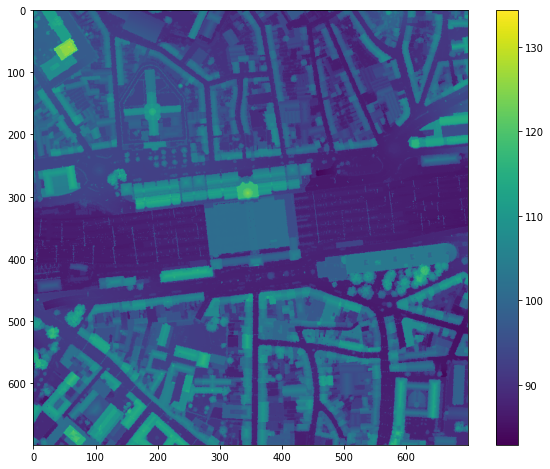

In [8]:
coordinates = (
    (p[0].x, p[0].y),
)

# Window's size
N = 700

print(path_dsm)

with rio.open(path_dsm) as dsm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dsm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dsm = dsm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
        dsm_meta = dsm.profile

plt.figure(figsize=(10, 8))
plt.imshow(small_dsm)
plt.colorbar()
plt.show()

##### DTM

Pixel Y, X coords: 21186, 41046


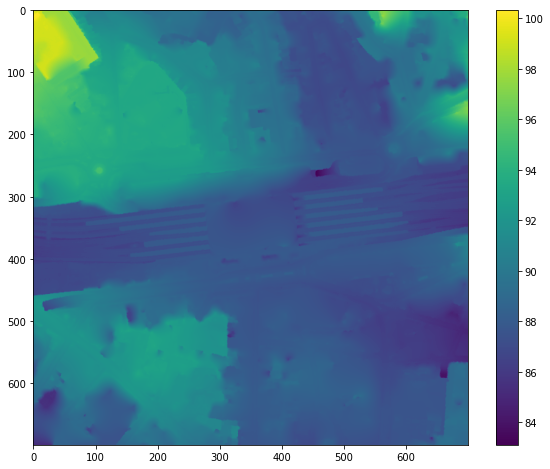

In [9]:
with rio.open(path_dtm) as dtm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dtm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dtm = dtm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
        dtm_meta = dtm.profile

plt.figure(figsize=(10, 8))
plt.imshow(small_dtm)
plt.colorbar()
plt.show()

In [35]:
dtm_meta

#  out_meta.update({"driver": "GTiff",
#                 "height": out_image.shape[0],
#                 "width": out_image.shape[1],
#                 "transform": out_transform })
                 #'nodata': no_data})

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 80000, 'height': 98000, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 144000.000000004,
       0.0, -1.0, 149999.9999999993), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

## Canopy Height Model

[Highlight on Canopy Height Model and Hillshade](https://github.com/Demesmaeker/3D_Houses/blob/main/App/Highlight%20on%20the%20Canopy%20Height%20Model%20and%20Hillshade.ipynb)

In [10]:
lidar_chm = small_dsm - small_dtm

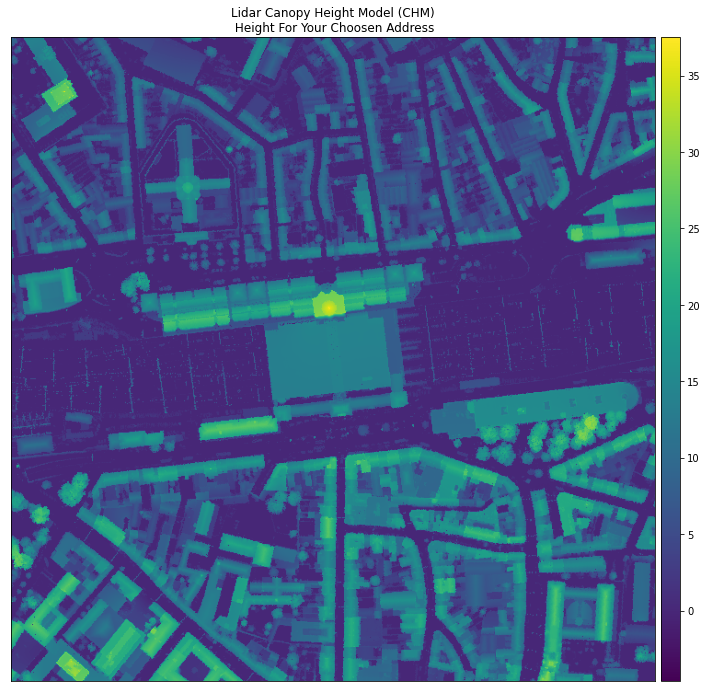

<Figure size 720x576 with 0 Axes>

In [11]:
ep.plot_bands(lidar_chm,
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)\n Height For Your Choosen Address")
plt.figure(figsize=(10, 8))
plt.show()

## Cleaning

In [14]:
# CLEANUP: Set CHM values of 1 or less to NAN
clean_lidar_chm = small_dsm - small_dtm
clean_lidar_chm[clean_lidar_chm <= 1] = np.nan

# View summary statistics of canopy height model after cleaning up the data
print('Mean:', np.nanmean(lidar_chm))
print('Max:', np.nanmax(lidar_chm))
print('Min:', np.nanmin(lidar_chm))
print('________________')
print('Mean:', np.nanmean(clean_lidar_chm))
print('Max:', np.nanmax(clean_lidar_chm))
print('Min:', np.nanmin(clean_lidar_chm))

Mean: 6.3350453
Max: 37.489265
Min: -4.6289215
________________
Mean: 10.663628
Max: 37.489265
Min: 1.0000305


## Transform raster into xyz datas

In [ ]:
# lidar_chm
# clean_lidar_chm

In [18]:
lidarray = np.array(lidar_chm)
lidarray

array([[9.1814728e+00, 8.9845963e+00, 9.4300003e+00, ..., 6.6800003e+00,
        5.1299973e+00, 0.0000000e+00],
       [9.1471558e+00, 8.9383469e+00, 9.2852249e+00, ..., 5.8799973e+00,
        9.3699951e+00, 9.6752167e-01],
       [9.1233673e+00, 8.8849411e+00, 8.7281723e+00, ..., 9.9400024e+00,
        8.8600006e+00, 1.0500000e+01],
       ...,
       [2.1714127e+01, 2.1748665e+01, 1.5863907e+01, ..., 0.0000000e+00,
        5.0048828e-03, 4.9972534e-03],
       [2.1786285e+01, 1.5931557e+01, 1.5967781e+01, ..., 1.0002136e-02,
        3.3340454e-03, 9.9945068e-03],
       [2.1938515e+01, 1.6006065e+01, 1.6073555e+01, ..., 1.9996643e-02,
        1.4999390e-02, 0.0000000e+00]], dtype=float32)

In [19]:
lidarray.shape

(700, 700)

In [20]:
lidar_chm.size

490000

In [23]:
type(lidar_chm)

numpy.ma.core.MaskedArray

In [40]:
shape = [{'type': 'Polygon', 
          'coordinates': [[(x+100, y+100), 
                           (x+100, y-100), 
                           (x-100, y+100), 
                           (x-100, y-100)]]}]

In [50]:
def get_dsm(path_dsm):
    with rio.open(path_dsm) as dsm:  
        out_image, out_transform = rio.mask.mask(dsm, shapes=shape, all_touched=True, crop=True)
        out_meta = dsm.meta

        # Remove the third axis (check if also in Flanders)
        out_image = np.moveaxis(out_image.squeeze(), -1, 0)

        # Update the new tiff file metadata
        out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[0],
                     "width": out_image.shape[1],
                     "transform": out_transform })
                     #'nodata': no_data})
    return out_image, out_meta

In [44]:
with rio.open(path_dtm) as dtm:  
    out_image, out_transform = rio.mask.mask(dtm, shapes=shape, all_touched=True, crop=True)
    out_meta = dtm.meta

    # Remove the third axis (check if also in Flanders)
    out_image = np.moveaxis(out_image.squeeze(), -1, 0)

    # Update the new tiff file metadata
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[0],
                 "width": out_image.shape[1],
                 "transform": out_transform })
                 #'nodata': no_data})

In [51]:
class Raster2xyz(object):

    def __init__(self, verbose=True):
      pass

    def __geotrCoords(self, gtr, x, y):
      try:
        gtr_x = x
        gtr_y = - y

        return(gtr_x, gtr_y)

      except Exception as err:
        self.__logger.error("Error getting geotransformed coordinates: {0}".format(err))

    def __getXyzData(self, raster_values, no_data):

        try:
            y, x = np.where(raster_values != no_data)
            data_vals = np.extract(raster_values != no_data, raster_values)

            return(x, y, data_vals)

        except Exception as err:
            print("Error getting XYZ data: {0}".format(err))

    def __buildXyzData(self, gtr_x, gtr_y, data_vals):

        try:
            data_dict = {
                "x": gtr_x,
                "y": gtr_y,
                "z": data_vals
            }

            return pd.DataFrame(data_dict)

        except Exception as err:
            print("Error building XYZ data: {0}".format(err))
    
    def __convert_meta(self, meta):
      return (meta[2], meta[0], meta[1], meta[5], meta[3], meta[4])
    
    def translate_from_cropped(self, crop_result, no_data=-9999):

      # Clean the received data
      raster, meta = crop_result
      meta = self.__convert_meta(meta['transform'])

      # Prepare the transformation
      x, y, data_vals = self.__getXyzData(raster, no_data)
      gtr_x, gtr_y = self.__geotrCoords(meta, x, y)

      return self.__buildXyzData(gtr_x, gtr_y, data_vals), (meta[0], meta[3])


raster2xyz = Raster2xyz()

In [52]:
test = raster2xyz.translate_from_cropped(get_dsm(path_dsm, shape))

In [57]:
test[0].head()

,x,y,z
0,0,0,92.830002
1,1,0,92.790001
2,2,0,92.720001
3,3,0,92.678787
4,4,0,92.610001


In [59]:
test[1]

(184946.000000004, 128913.9999999993)

## Saving some files

In [ ]:
with rio.open('../Outputs/small_dsm.tiff', 'w', **dsm_meta) as ff:
    ff.write(small_dsm,1)

In [ ]:
with rio.open('../Outputs/small_dtm.tiff', 'w', **dtm_meta) as ff:
    ff.write(small_dtm,1)

In [ ]:
with rio.open('../Outputs/lidar_chm.tiff', 'w', **dsm_meta) as ff:
    ff.write(lidar_chm,1)

TO DO :
    
Flandre :
    "Get the file"
    analyser shapefile pour obtenir coordonnées min/max
    selectionner les bons fichiers
    avoir le système de référence (crs)
    transformer coord das le système de référence
    
Les deux :
    Projection 3D
    Select one house only
    